In [1]:
# Импорт библиотек для работы вне Jupyter Notebook
from typing import List, Union, Any, Tuple, Dict, Callable, Optional

import numpy as np
import pandas as pd

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, GlobalAveragePooling1D, Input
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPool1D, concatenate
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
from keras.utils import to_categorical
import keras.backend as K
from keras.models import Model

from keras.preprocessing import text as keras_text, sequence as keras_seq
from keras.callbacks import EarlyStopping, ModelCheckpoint
#from keras_text.processing import CharTokenizer

from IPython.core.display import display, HTML, Latex


def write_to_submission_file(predicted_labels: Union[pd.DataFrame, np.ndarray],
                             out_file: str,
                             target: str = 'target',
                             index_label: str = 'session_id') -> None:
    """Вспомогательная функция, записывающая файл результатов для отправки на Kagle

    :param predicted_labels: Предсказанные значения
    :param out_file:         Название файла, в который пишутся результаты
    :param target:           Заголовок столбца предсказанных значений
    :param index_label:      Заголовок столбца индексной переменной
    :return:                 Значение не возвращает, создает файл с именем out_file
    """
    predicted_df: pd.DataFrame = pd.DataFrame(predicted_labels,
                                              #index=np.arange(1, predicted_labels.shape[0] + 1),
                                              columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)
    return None


Using TensorFlow backend.


In [2]:
# Загружаем обучающую и тестовую выборки
train_df: pd.DataFrame = pd.read_csv('train.csv', dtype={'Password': str, 'Times': int})

test_df: pd.DataFrame = pd.read_csv('Xtest.csv', index_col='Id')



/home/vadim/anaconda3/envs/dmia_py36/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


### Ищем пропуски

In [3]:
def is_nans(df: pd.DataFrame) -> None:
    """Находит пропущенные значения
    
    :param df: Таблица, в которой ищутся пропуски
    :return:   None, печатает DataFrame с пропущенными значениями либо, что значений нет.
    """
    nans: pd.DataFrame = df.isnull()
    if(nans.values.any()):
        print('Eсть пропущенные значения!')
        display(df[nans.values])
    else:
        print('Нет пропущенных значений!')
    
is_nans(train_df)
is_nans(test_df)

Eсть пропущенные значения!


,Password,Times
66233,NaN,27
157331,NaN,3


Eсть пропущенные значения!


,Password
Id,
581317,NaN


Смотрим в файле, в соответствующих строках:
В обучающей выборке на строке 66235 стоит пустой пароль, а в строке 157333 стоит пароль nan.

Pandas определяет их как пароли без значения, это приводит к <b>противоречивости в данных</b> (т. к. разные значения Times). Поскольку люди чаще ставят путой пароль, чем пароль "nan", удаляем строку с паролем "nan", а пустой пароль заменяем на "null999".

В тестовой выборке в строке с Id 581317 стоит пароль "null", заменим его тоже на "null999", чтобы значения совпадали с  обучающей выборкой.

In [4]:
train_df.drop(157331, inplace=True)
train_df.fillna('null999', inplace=True)
test_df.fillna('null999', inplace=True)
# Проверяем
is_nans(train_df)
is_nans(test_df)

Нет пропущенных значений!
Нет пропущенных значений!


### Ищем дубликаты

In [5]:
dupes_train: pd.DataFrame = train_df[train_df.duplicated(keep=False)]
dupes_test: pd.DataFrame = test_df[test_df.duplicated(keep=False)]
display(HTML(f'В обучающей выборке <b>{dupes_train.shape[0]} дубликатов</b>'))
display(HTML(f'В тестовой выборке <b>{dupes_test.shape[0]} дубликатов</b>\n'))

### Количество уникальных значений
Если рассматривать задачу, как задачу классификации

In [6]:
train_df['Times'].nunique()

823

Убираем 0.05% наиболее састо встречающихся данных (считаем, что это выбросы),чтобы сделать выборку более сбалансированной и уменьшить количество уникальных значений

In [7]:
q_0005 = train_df["Times"].quantile(q=0.9995)
train_df_cleaned = train_df.drop(train_df[train_df['Times'] > q_0005].index)
print(f'Количество уникальных значений в исходном файле: {train_df["Times"].nunique()}\n'
      f'Количество уникальных значений в измененном файле: {train_df_cleaned["Times"].nunique()}')

Количество уникальных значений в исходном файле: 823
Количество уникальных значений в измененном файле: 162


In [8]:
print(f'Количество наиболее часто встречающихся объектов, '
      f'которые выбрасываем из выборки: {train_df.shape[0] - train_df_cleaned.shape[0]}')

Количество наиболее часто встречающихся объектов, которые выбрасываем из выборки: 2073


Посчитаем максимальную длину пароля в обучающей и тестовой выборках

In [9]:
train_df_cleaned.loc[:, 'length'] = train_df_cleaned['Password'].apply(lambda x: len(str(x)))
test_df.loc[:, 'length'] = test_df['Password'].apply(lambda x: len(str(x)))
maxlen = train_df_cleaned['length'].max()
maxlen_test = test_df['length'].max()

print(f'Максимальная длина пароля в обучающей выборке {maxlen}\n'
      f'Максимальная длина пароля в тестовой выборке {maxlen_test}')

Максимальная длина пароля в обучающей выборке 42
Максимальная длина пароля в тестовой выборке 39


In [10]:
# Подготовим данные для Keras
# Обучающая выборка
list_sentences_train = list(train_df_cleaned['Password'].values)
list_sentences_train=list(map(str,list_sentences_train))

# Тестовая выборка
list_sentences_test = list(test_df['Password'].values)
list_sentences_test=list(map(str,list_sentences_test))

# Кодируем y по типу One Hot Encoding (нужно, чтобы в Keras работала многоклассовая класссификация)
y = train_df_cleaned['Times'].values
y_encoded = to_categorical(y)  # to_categorical делает количество столбцов от 0 до числа классов

Получившиеся размерности столбца ответов (исходного и измененного для Keras)

In [11]:
y.shape, y_encoded.shape

((4149422,), (4149422, 163))

In [12]:
# Преобразуем пароли в токены
tokenizer = keras_text.Tokenizer(char_level = True, filters='', lower=False)
tokenizer.fit_on_texts(list_sentences_train)

# Обучающая выборка
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
X_t = keras_seq.pad_sequences(list_tokenized_train, padding='post', maxlen=maxlen)

# Тестовая выборка
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_te = keras_seq.pad_sequences(list_tokenized_test, padding='post', maxlen=maxlen)

In [13]:
# Определяем метрику RMSLE, чтобы использовать в качестве дополнительной метрики при обучении

def rmsle_K(y_true, y_pred):
    
    y_pred_decoded = K.cast(K.argmax(y_pred, axis=-1), dtype='float32')
    y_true_decoded = K.cast(K.argmax(y_true, axis=-1), dtype='float32')
    return K.sqrt(K.mean(K.square(tf.log1p(y_pred_decoded) - tf.log1p(y_true_decoded)), axis=-1))

### Baseline 1

Используем код для классификации текстов из 1 семинара по DL DMIA_2019

In [14]:
vocab_size = len(tokenizer.word_counts)

model_dl = Sequential()

# Превращаем пароли в embendings по 16 символов
model_dl.add(Embedding(vocab_size, 16))

model_dl.add(GlobalAveragePooling1D())

# Количество нейронов = количеству различных чисел в столбце "Times"
model_dl.add(Dense(units=y_encoded.shape[1], activation='relu'))

model_dl.add(Dropout(0.5))
model_dl.add(Dense(units=y_encoded.shape[1], activation='softmax'))# Многоклассовая классификация

model_dl.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          1552      
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 163)               2771      
_________________________________________________________________
dropout_1 (Dropout)          (None, 163)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 163)               26732     
Total params: 31,055
Trainable params: 31,055
Non-trainable params: 0
_________________________________________________________________


#### Нарисуем архитектуру сети

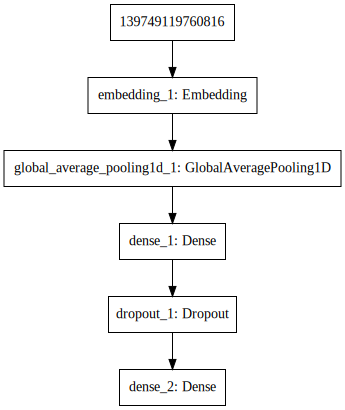

In [15]:
from IPython.display import SVG, Image
SVG(model_to_dot(model_dl).create(prog='dot', format='svg'))

In [16]:
opt = Adam(lr=0.001)

model_dl.compile(optimizer=opt,
                 loss='categorical_crossentropy',
                 metrics=['accuracy', rmsle_K])

In [17]:
from sklearn.model_selection import train_test_split

print('Количество объектов в зависимости от частоты встречаемости пароля')
print('Важно для стратификации при валидации')
print(pd.value_counts(y))

# Разделяем обучающую выборку на, собственно, обучающую и "валидационную" 
X_t_train, X_t_test, y_train, y_test = train_test_split(X_t, y_encoded, 
                                                        test_size = 0.2, 
                                                        stratify = y,
                                                       random_state = 17)
print(f'Размер Train: {X_t_train.shape}')
print(f'Размер Test: {X_t_test.shape}')

Количество объектов в зависимости от частоты встречаемости пароля
Важно для стратификации при валидации
1      3547155
2       309205
3        96461
4        47704
5        27903
6        18627
7        13635
8        10567
9         8235
10        6775
11        5546
12        4818
13        4175
14        3565
15        3111
16        2699
17        2553
18        2222
19        2002
20        1887
21        1774
22        1578
23        1483
24        1388
25        1243
26        1152
27        1099
29         963
28         928
30         875
        ...   
125         24
138         23
152         23
149         22
128         21
144         21
133         20
132         20
131         20
142         20
145         19
135         18
157         18
158         17
156         17
161         17
146         17
148         16
150         16
155         16
134         16
162         16
154         15
137         15
159         14
147         12
153         12
141         12
151        

In [18]:
# Проверяем размерности данных
X_t_train.shape, y_train.shape, X_t_test.shape, y_test.shape

((3319537, 42), (3319537, 163), (829885, 42), (829885, 163))

#### Обучаем модель

In [19]:
history = model_dl.fit(x=X_t_train,
                       y=y_train,
                       epochs=5,
                       batch_size=1024,
                       validation_data=(X_t_test, y_test),
                       verbose=1)

Train on 3319537 samples, validate on 829885 samples
Epoch 1/5
3319537/3319537 [==============================] - 11s 3us/step - loss: 0.7702 - acc: 0.8539 - rmsle_K: 0.4142 - val_loss: 0.6681 - val_acc: 0.8549 - val_rmsle_K: 0.4106
Epoch 2/5
3319537/3319537 [==============================] - 10s 3us/step - loss: 0.6773 - acc: 0.8549 - rmsle_K: 0.4106 - val_loss: 0.6673 - val_acc: 0.8549 - val_rmsle_K: 0.4106
Epoch 3/5
3319537/3319537 [==============================] - 10s 3us/step - loss: 0.6736 - acc: 0.8549 - rmsle_K: 0.4105 - val_loss: 0.6658 - val_acc: 0.8549 - val_rmsle_K: 0.4106
Epoch 4/5
3319537/3319537 [==============================] - 10s 3us/step - loss: 0.6715 - acc: 0.8549 - rmsle_K: 0.4106 - val_loss: 0.6654 - val_acc: 0.8549 - val_rmsle_K: 0.4106
Epoch 5/5
3319537/3319537 [==============================] - 10s 3us/step - loss: 0.6700 - acc: 0.8548 - rmsle_K: 0.4106 - val_loss: 0.6644 - val_acc: 0.8549 - val_rmsle_K: 0.4106


#### Кривые обучения

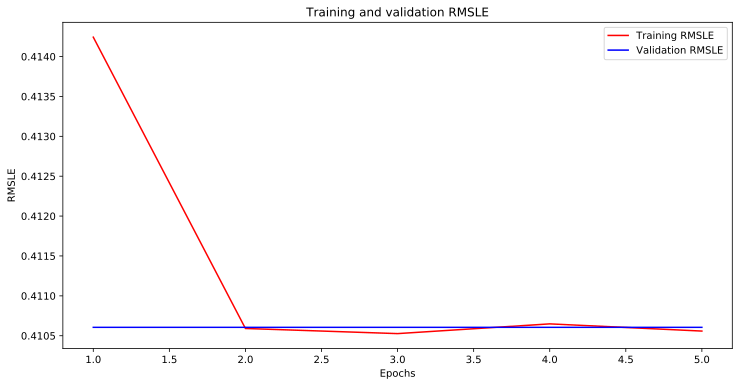

In [20]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
# Делаем одинаковый размер картинок в matplotlib notebook и matplotlib inline
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg'


fig = plt.figure(figsize=(12, 6))

epochs = range(1, len(history.history['loss']) + 1)

#plt.plot(epochs, history.history['loss'], 'r', label='Training loss')
#plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.plot(epochs, history.history['rmsle_K'], 'r', label='Training RMSLE')
plt.plot(epochs, history.history['val_rmsle_K'], 'b', label='Validation RMSLE')

plt.title('Training and validation RMSLE')
plt.xlabel('Epochs')
plt.ylabel('RMSLE')
plt.legend()

plt.show()

#### Делаем предсказание и смотрим качество на тестовой выборке

In [21]:
preds_test = model_dl.predict(X_t_test, verbose=1, batch_size=1024)

829885/829885 [==============================] - 1s 1us/step


In [22]:
# Обратное преобразование от to_categorical(y)
preds_test_decoded = np.argmax(preds_test, axis=1)
y_test_decoded = np.argmax(y_test, axis=1)

In [23]:
# rmsle для расчетов вне Keras
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

In [24]:
print(f'RMSLE на валидирующей выборке {rmsle(y_test_decoded, preds_test_decoded)}')

RMSLE на валидирующей выборке 0.4120602981582498


## Попробуем более продвинутую архитектуру сети
### Embendings + 1D CNN + n-gramms

Возьмем код <a href="https://www.kaggle.com/kmader/character-level-cnn-classification-with-dilations">отсюда</a>

In [25]:
def build_model(conv_layers = 2, 
                dilation_rates = [0, 1, 2, 3, 4, 5], 
                embed_size = 16):
    inp = Input(shape=(None, ))
    x = Embedding(input_dim = len(tokenizer.word_counts)+1, 
                  output_dim = embed_size)(inp)
    prefilt_x = Dropout(0.25)(x)
    out_conv = []
    # dilation rate lets us use ngrams and skip grams to process 
    for dilation_rate in dilation_rates:
        x = prefilt_x
        for i in range(2):
            if dilation_rate>0:
                x = Conv1D(16*2**(i), 
                           kernel_size = 3, 
                           dilation_rate = dilation_rate,
                          activation = 'relu',
                          name = 'ngram_{}_cnn_{}'.format(dilation_rate, i)
                          )(x)
            else:
                x = Conv1D(16*2**(i), 
                           kernel_size = 1,
                          activation = 'relu',
                          name = 'word_fcl_{}'.format(i))(x)
        out_conv += [Dropout(0.5)(GlobalMaxPool1D()(x))]
    x = concatenate(out_conv, axis = -1)    
    x = Dense(y_encoded.shape[1], activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(y_encoded.shape[1], activation='softmax')(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', rmsle_K])
    return model

model = build_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 16)     1568        input_1[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, None, 16)     0           embedding_2[0][0]                
__________________________________________________________________________________________________
word_fcl_0 (Conv1D)             (None, None, 16)     272         dropout_2[0][0]                  
__________________________________________________________________________________________________
ngram_1_cn

### Нарисуем архитектуру сети

In [26]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

<img src="model_plot.png">

#### Обучаем сеть

In [28]:
batch_size = 1024 # large enough that some other labels come in
epochs = 15

file_path="best_weights.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss",  # Смотрим на loss на валидации
                      mode="min",  # loss перестает уменьшаться
                      patience=5  # на протяжении 5 эпох
                     )

callbacks_list = [checkpoint, early] #early
history_2 = model.fit(X_t_train, y_train, 
                      validation_data=(X_t_test, y_test),
                      batch_size=batch_size, 
                      epochs=epochs, 
                      shuffle = True,
                      callbacks=callbacks_list)

Train on 3319537 samples, validate on 829885 samples
Epoch 1/15
3319537/3319537 [==============================] - 87s 26us/step - loss: 0.6208 - acc: 0.8551 - rmsle_K: 0.3765 - val_loss: 0.6149 - val_acc: 0.8554 - val_rmsle_K: 0.3622

Epoch 00001: val_loss improved from inf to 0.61487, saving model to best_weights.h5
Epoch 2/15
3319537/3319537 [==============================] - 87s 26us/step - loss: 0.6201 - acc: 0.8550 - rmsle_K: 0.3756 - val_loss: 0.6130 - val_acc: 0.8553 - val_rmsle_K: 0.3608

Epoch 00002: val_loss improved from 0.61487 to 0.61299, saving model to best_weights.h5
Epoch 3/15
3319537/3319537 [==============================] - 87s 26us/step - loss: 0.6196 - acc: 0.8551 - rmsle_K: 0.3746 - val_loss: 0.6130 - val_acc: 0.8554 - val_rmsle_K: 0.3625

Epoch 00003: val_loss did not improve from 0.61299
Epoch 4/15
3319537/3319537 [==============================] - 87s 26us/step - loss: 0.6191 - acc: 0.8551 - rmsle_K: 0.3742 - val_loss: 0.6127 - val_acc: 0.8554 - val_rmsle_K: 

#### Кривые обучения

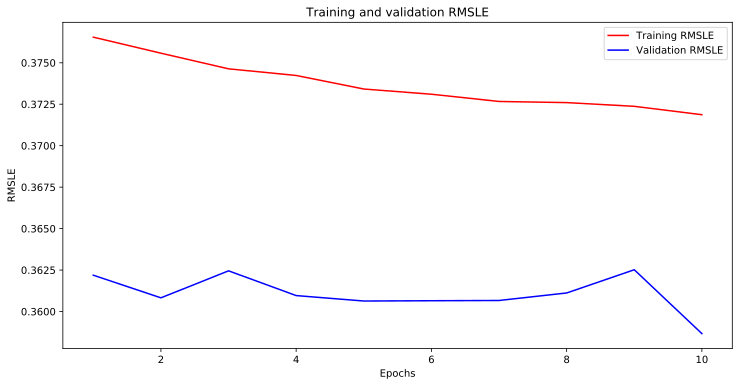

In [30]:
fig = plt.figure(figsize=(12, 6))

epochs = range(1, len(history_2.history['loss']) + 1)

#plt.plot(epochs, history_2.history['loss'], 'r', label='Training loss')
#plt.plot(epochs, history_2.history['val_loss'], 'b', label='Validation loss')
plt.plot(epochs, history_2.history['rmsle_K'], 'r', label='Training RMSLE')
plt.plot(epochs, history_2.history['val_rmsle_K'], 'b', label='Validation RMSLE')

plt.title('Training and validation RMSLE')
plt.xlabel('Epochs')
plt.ylabel('RMSLE')
plt.legend()

plt.show()

In [31]:
# Загружаем веса модели и делаем предсказание
model.load_weights(file_path)

preds_test = model.predict(X_t_test, verbose=1, batch_size=1024)

# Обратное преобразование от to_categorical(y)
preds_test_decoded = np.argmax(preds_test, axis=1)
y_test_decoded = np.argmax(y_test, axis=1)


print(f'RMSLE на валидирующей выборке {rmsle(y_test_decoded, preds_test_decoded)}')

829885/829885 [==============================] - 6s 7us/step
RMSLE на валидирующей выборке 0.3620774036867824


In [32]:
# Делаем предсказание для отправки на Kaggle
y_predict = model.predict(X_te)

In [33]:
# Обратное преобразование от to_categorical(y)
y_predict_decoded = np.argmax(y_predict, axis=1)

In [34]:
# Отсылаем на Kaggle
write_to_submission_file(predicted_labels=y_predict_decoded,
                             out_file='china_net1.csv',
                             target='Times',
                             index_label='Id')

Данная посылка дает Private Score 0.38215, что немного моеньше, чем зафиксировано на момент окончания конкурса (0.38508).

Вывод&nbsp;&mdash; надо строить кривые обучения и правильно подбирать размеры выборок (результат 0.38508 получен, если разбивать выборку в соотношении 70:30). 